In [22]:
# DATA CLEANING
import pandas as pd
df = pd.read_csv('events.csv')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from datetime import datetime
df['date'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
df.head()

,timestamp,visitorid,event,itemid,transactionid,date
0,1433221332117,257597,view,355908,NaN,2015-06-02 07:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 07:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 07:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 07:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 07:02:17.106


In [46]:
# DATASET TRANSACTIONS
# Diviser les events entre transactions et le reste
non_transactions = df.loc[df.event != "transaction"]
transactions = df.loc[df.event == "transaction"]

# Merger les deux tableaux afin de calculer le temps passé entre 2 actions successives
inner_merged_total = pd.merge(transactions, non_transactions, on=["visitorid"], how="inner")

# Trier le dataframe par visitorid...
inner_merged_total = inner_merged_total.sort_values(by=['visitorid','date_x','date_y','itemid_x'])

# time_diff est moins de 24h et le itemid sur lequel la transaction 
# a eu lieu et le itemid sur lequel chaque événement s'est produit doivent être les mêmes
inner_merged_total['event_diff_second'] = inner_merged_total['date_x'] - inner_merged_total['date_y']
inner_merged_total['event_diff_second'] = inner_merged_total['event_diff_second'] / np.timedelta64(1, 's')

transaction_24h = inner_merged_total.loc[inner_merged_total['event_diff_second'] < 86400]
transaction_made_24h = transaction_24h.loc[inner_merged_total['itemid_x'] == inner_merged_total['itemid_y']]

# Supprimer certaines colonnes
transaction_made_24h = transaction_made_24h.drop(['timestamp_x','timestamp_y','transactionid_y'], axis=1)
#transaction_made_24h

transaction_made_24h.loc[transaction_made_24h.transactionid_x == 9725]

,visitorid,event_x,itemid_x,transactionid_x,date_x,event_y,itemid_y,date_y,event_diff_second
10069099,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:06:38.438,1342.792
10069108,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:39.691,921.539
10069105,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:48.324,912.906
10069098,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:09.037,112.193
10069106,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:27.421,93.809
10069137,172,transaction,10034,9725.0,2015-08-15 03:29:01.686,view,10034,2015-08-15 02:49:12.998,2388.688
10069136,172,transaction,10034,9725.0,2015-08-15 03:29:01.686,addtocart,10034,2015-08-15 02:50:16.912,2324.774


In [31]:
# Grouper par le transactionid et la date d'evenement
calcul_time = pd.DataFrame(transaction_made_24h,columns=['transactionid_x','visitorid','date_y'])
calcul_time['time_diff_sec'] = calcul_time.sort_values(['transactionid_x','date_y']).groupby('transactionid_x')['date_y'].diff().dt.seconds

# Calculer le temps moyen
calcul_mean_time = calcul_time.groupby(by=['transactionid_x']).mean()
calcul_mean_time = calcul_mean_time.rename(columns={"time_diff_sec": "mean_time_second"})
calcul_mean_time = calcul_mean_time.fillna(0)

time_1_event = calcul_mean_time.loc[calcul_mean_time.mean_time_second == 0]
time_1_event = pd.merge(time_1_event, transaction_made_24h, on=["transactionid_x"], how="left")
time_1_event = pd.DataFrame(time_1_event,columns=['transactionid_x','event_diff_second']).set_index('transactionid_x')
time_1_event = time_1_event.rename(columns={"event_diff_second": "mean_time_second"})

# Créer le tableau final du temps moyen par transaction en combiant les deux tableaux ci-dessus
time_mean_transaction = time_1_event.combine_first(calcul_mean_time)
time_mean_transaction['mean_time_minute'] = round(time_mean_transaction['mean_time_second']/60)
time_mean_transaction['mean_time_hour'] = round(time_mean_transaction['mean_time_second']/3600,2)

# Ajouter item list
aggregation = {'itemid': list}
item_list_transaction = df.groupby(['transactionid']).agg(aggregation)
time_mean_transaction['item_list'] = item_list_transaction['itemid']
time_mean_transaction

,mean_time_second,visitorid,mean_time_minute,mean_time_hour,item_list
transactionid_x,,,,,
0.0,32075.0,90352.0,535.0,8.91,[425758]
1.0,24755.5,1150086.0,413.0,6.88,[454430]
2.0,189.0,556967.0,3.0,0.05,[151855]
3.0,18736.0,424452.0,312.0,5.20,[85842]
4.0,9306.0,531661.0,155.0,2.58,[224184]
...,...,...,...,...,...
17667.0,17198.0,368819.0,287.0,4.78,[433567]
17668.0,25.0,1297062.0,0.0,0.01,[212289]
17669.0,1848.8,163561.0,31.0,0.51,"[132418, 260256]"


In [51]:
# Calculer le temps moyen sur transaction par acheteur
time_mean_visitor = time_mean_transaction.groupby(by=['visitorid']).mean()
time_mean_visitor

# Nombre de visites
stats = df.groupby('visitorid').agg({'visitorid':'count'})
stats = stats.rename(columns={"visitorid": "nb_visites"})

# Nombre de views par visitorid
view = df.loc[df['event'] == 'view'].groupby('visitorid').agg({'visitorid':'count'})
view = view.rename(columns={"visitorid": "nb_views"})

# Nombre de addtocarts par visitorid
addtocart = df.loc[df['event'] == 'addtocart'].groupby('visitorid').agg({'visitorid':'count'})
addtocart = addtocart.rename(columns={"visitorid": "nb_addtocarts"})

#### STATS PAR VISITEUR #####
# Nombre de transactions par visitorid
transaction = df.loc[df['event']=='transaction'].groupby(by=['visitorid','transactionid'], as_index=False).agg({'itemid': 'count'})
all_transaction=transaction.groupby(by='visitorid').agg({'transactionid': 'count'}).rename(columns={"transactionid": "nb_transactions"})

# Merge les dataframes
stats = pd.merge(stats, view, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, addtocart, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, all_transaction, left_index=True, right_index=True, how='left')

# Merge items
items = df.loc[df['transactionid'] > 0].groupby(by='visitorid').agg({'itemid': 'count'})
stats = pd.merge(stats, items, left_index=True, right_index=True, how='left')
stats = stats.rename(columns={"itemid": "nb_items_bought"})

# Merge avec temps moyen passé
stats = pd.merge(stats, time_mean_visitor, left_index=True, right_index=True, how='left')
stats = stats.fillna(0)
stats = stats.sort_values('nb_transactions', ascending=False)

# Supprimer le visiteur 1150086
stats = stats.drop(stats.head(1).index)
stats.head(20)

,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,mean_time_second,mean_time_minute,mean_time_hour
visitorid,,,,,,,,
152963,3024,2304.0,371.0,278.0,349.0,3652.221854,60.831541,1.014659
530559,4328,3623.0,419.0,221.0,286.0,3936.486262,65.601810,1.093303
684514,2246,1826.0,231.0,162.0,189.0,3585.990557,59.674847,0.995644
76757,1883,1402.0,296.0,155.0,185.0,2087.150176,34.740741,0.579383
861299,1991,1573.0,230.0,148.0,188.0,2914.733622,48.466667,0.809267
138131,1611,1231.0,207.0,137.0,173.0,3201.160590,53.313869,0.888978
247235,1698,1401.0,165.0,124.0,132.0,2673.858037,44.515873,0.742619
1297062,1822,1531.0,155.0,111.0,136.0,3595.921753,59.919643,0.998571
890980,1017,662.0,210.0,104.0,145.0,935.307683,15.528846,0.259423


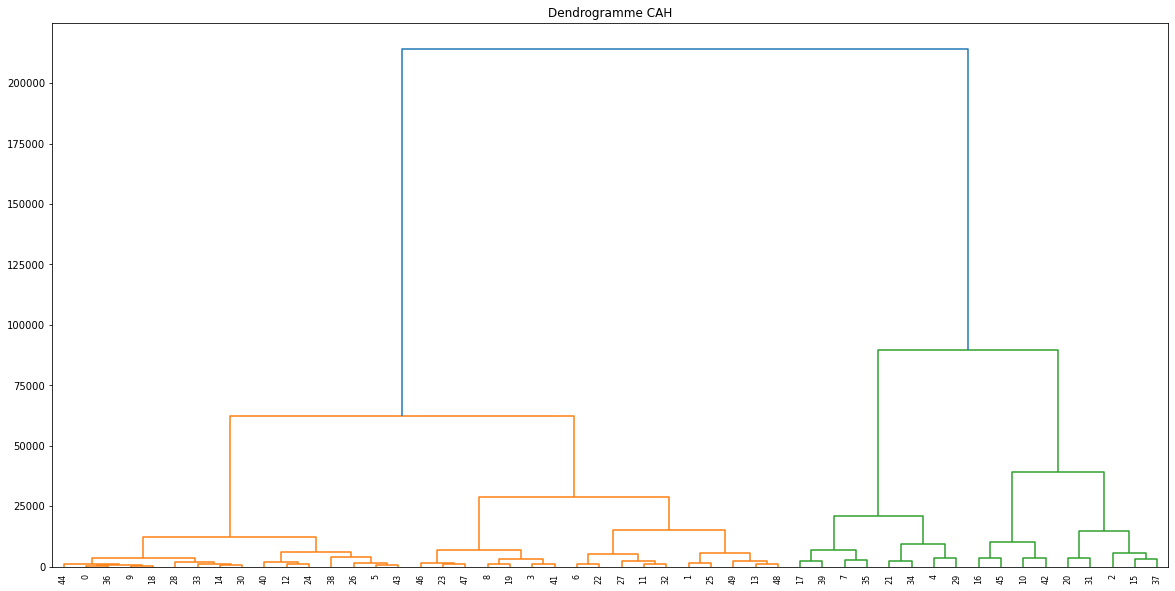

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,mean_time_second,mean_time_minute,mean_time_hour,kmean1_label,agglo_label,kmean2_label
visitorid,,,,,,,,,,,
152963,3024,2304.0,371.0,278.0,349.0,3652.221854,60.831541,1.014659,38,0.0,0
530559,4328,3623.0,419.0,221.0,286.0,3936.486262,65.601810,1.093303,38,0.0,0
684514,2246,1826.0,231.0,162.0,189.0,3585.990557,59.674847,0.995644,38,0.0,0
76757,1883,1402.0,296.0,155.0,185.0,2087.150176,34.740741,0.579383,28,0.0,0
861299,1991,1573.0,230.0,148.0,188.0,2914.733622,48.466667,0.809267,38,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
471122,1,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0.0,0
471121,1,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0.0,0
471120,2,2.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0.0,0


In [53]:
# CLUSTERING SUR STATS

k1 = KMeans(n_clusters=50).fit(stats)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

stats['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    stats.loc[stats['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = stats.groupby('agglo_label').mean()
new_stats = stats.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_stats)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

stats['kmean2_label'] = k2.labels_
stats

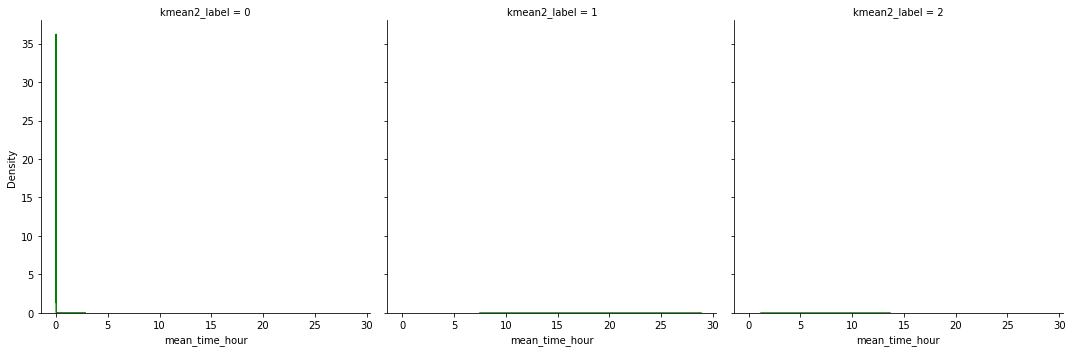

In [54]:
sns.displot(data=stats, x="mean_time_hour", col="kmean2_label", kind="kde", color='green')


Text(0.5, 1.0, "Le nombre d'ajouts aux paniers par visiteur")

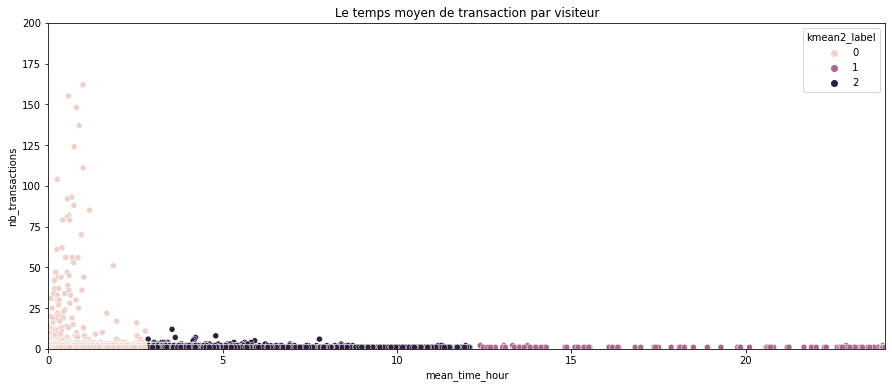

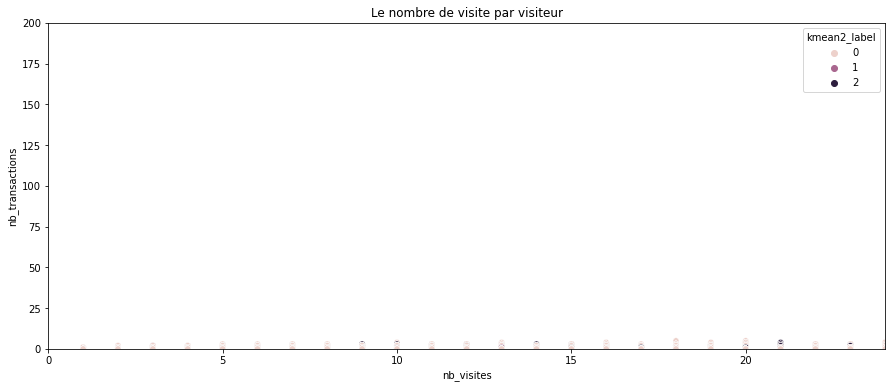

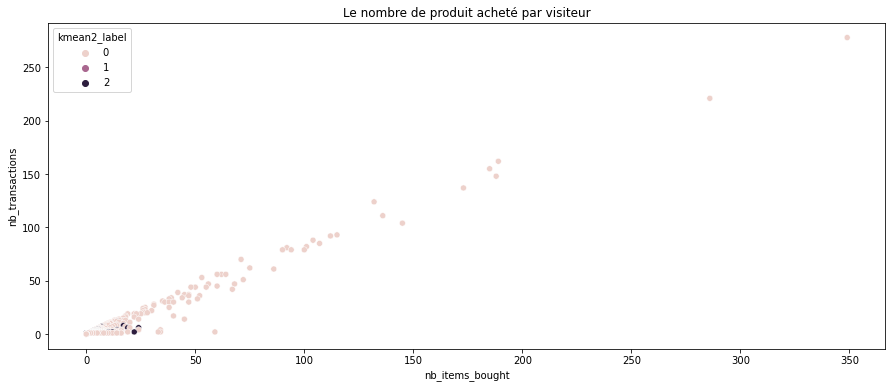

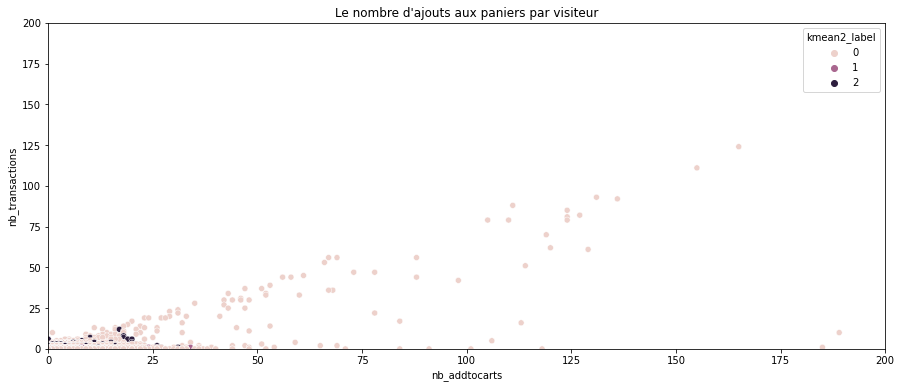

In [56]:
##### ANALYSES TABELEAU STATS (PAR VISITEUR)
plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="mean_time_hour", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le temps moyen de transaction par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_visites", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le nombre de visite par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_items_bought", y="nb_transactions", hue="kmean2_label")
#plt.xlim(0, 24)
#plt.ylim(0, 600)
plt.title('Le nombre de produit acheté par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_addtocarts", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.title("Le nombre d'ajouts aux paniers par visiteur")

In [ ]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="mean_time_hour", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le temps moyen de transaction par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_visites", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le nombre de visite par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_items_bought", y="nb_transactions", hue="kmean2_label")
#plt.xlim(0, 24)
#plt.ylim(0, 600)
plt.title('Le nombre de produit acheté par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_addtocarts", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.title("Le nombre d'ajouts aux paniers par visiteur")

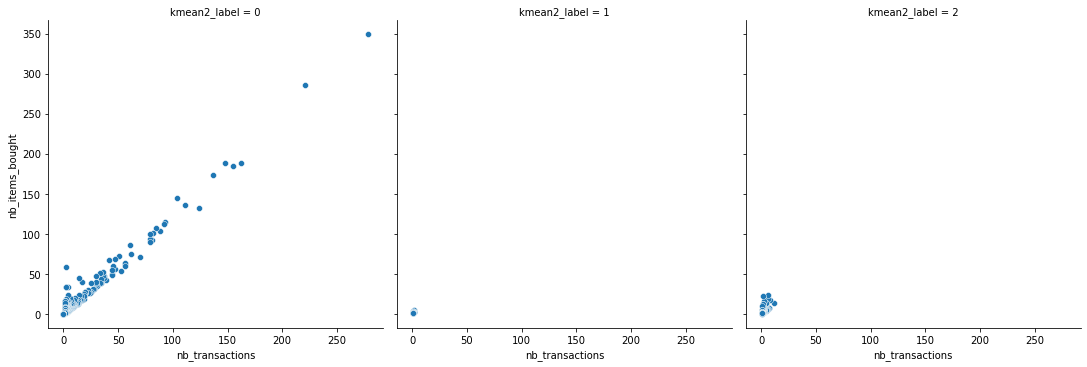

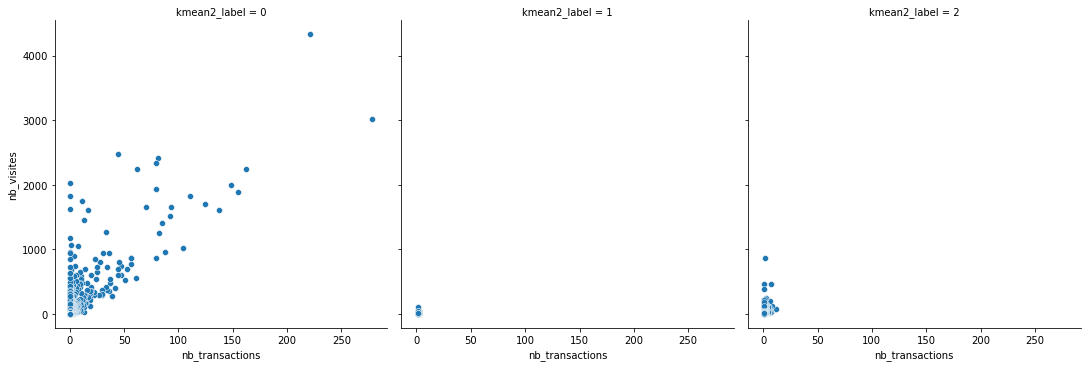

In [73]:
sns.relplot(
    data=stats, x="nb_transactions", y="nb_items_bought",
    col="kmean2_label",
    kind="scatter"
)

sns.relplot(
    data=stats, x="nb_transactions", y="nb_visites",
    col="kmean2_label",
    kind="scatter"
)

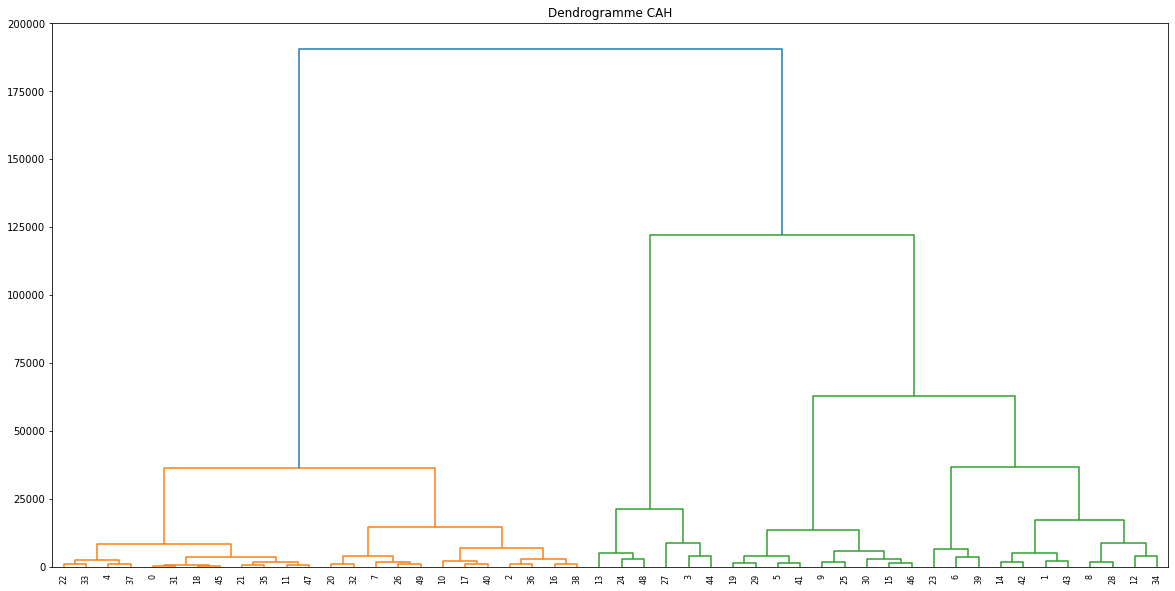

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,mean_time_second,mean_time_minute,mean_time_hour,kmean1_label,agglo_label,kmean2_label
transactionid_x,,,,,,
0.0,32075.000000,535.0,8.91,30,0.0,0
1.0,5048.666667,84.0,1.40,4,1.0,1
2.0,189.000000,3.0,0.05,0,1.0,1
4.0,9306.000000,155.0,2.58,7,1.0,1
6.0,5.000000,0.0,0.00,31,1.0,1
...,...,...,...,...,...,...
17667.0,17198.000000,287.0,4.78,40,1.0,0
17668.0,25.000000,0.0,0.01,31,1.0,1
17669.0,1848.800000,31.0,0.51,35,1.0,1


In [68]:
# CLUSTERING SUR time_mean_transaction
time_mean_transaction_clustering = time_mean_transaction.drop(['item_list','visitorid'], axis=1)

# CLUSTERING SUR time_mean_transaction_clustering

k1 = KMeans(n_clusters=50).fit(time_mean_transaction_clustering)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

time_mean_transaction_clustering['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    time_mean_transaction_clustering.loc[time_mean_transaction_clustering['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = time_mean_transaction_clustering.groupby('agglo_label').mean()
new_time_mean_transaction_clustering = time_mean_transaction_clustering.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_time_mean_transaction_clustering)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

time_mean_transaction_clustering['kmean2_label'] = k2.labels_
time_mean_transaction_clustering

Text(0.5, 1.0, 'Clustering')

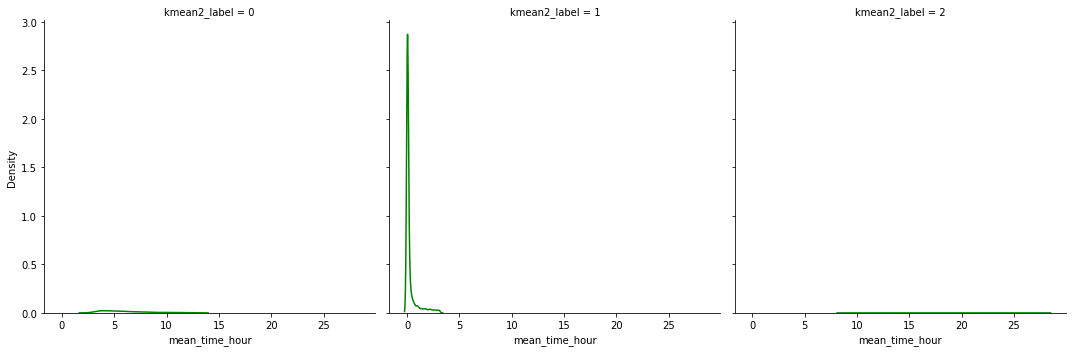

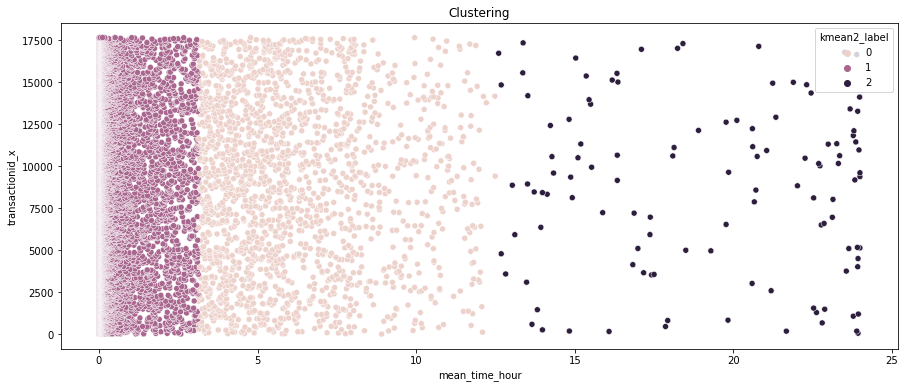

In [77]:
sns.displot(data=time_mean_transaction_clustering, x="mean_time_hour", col="kmean2_label", kind="kde", color='green')

import seaborn as sns
plt.figure(figsize=(15,6))
sns.scatterplot(data=time_mean_transaction_clustering, x="mean_time_hour", y=time_mean_transaction_clustering.index, hue="kmean2_label",)
plt.title('Clustering')

Text(0.5, 1.0, 'Temps moyens passé avant la transaction compris égale à moins de 10 minutes')

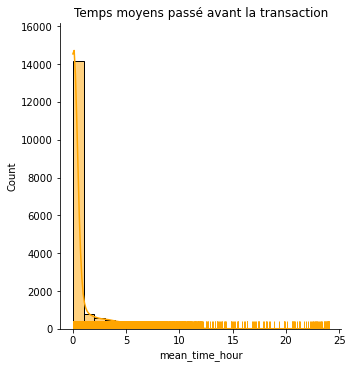

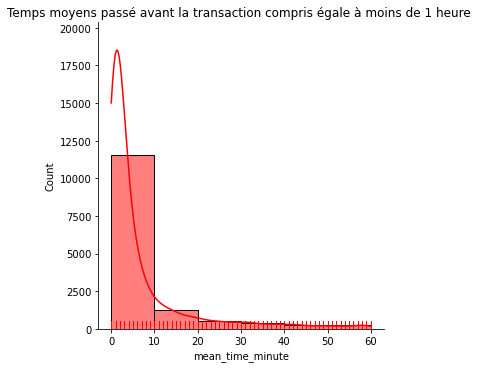

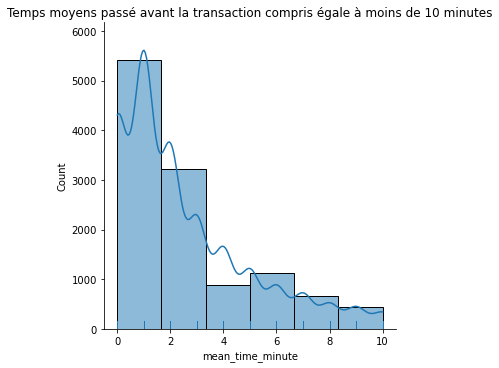

In [71]:
##### DATAVIZ ######
# Temps de Transactions moins d'une heure
mean_transaction_1h = time_mean_transaction.loc[round(time_mean_transaction['mean_time_minute']) <= 60]

# Temps de transactions moins de 10 minutes
mean_transaction_10minutes = mean_transaction_1h.loc[round(mean_transaction_1h['mean_time_minute']) <= 10]

sns.displot(time_mean_transaction['mean_time_hour'], bins=24, kde=True, rug=True, color='orange')
plt.title('Temps moyens passé avant la transaction')

sns.displot(mean_transaction_1h['mean_time_minute'], bins=6, kde=True, rug=True, color='red')
plt.title('Temps moyens passé avant la transaction compris égale à moins de 1 heure ')
          
sns.displot(mean_transaction_10minutes['mean_time_minute'], bins=6, kde=True, rug=True)
plt.title('Temps moyens passé avant la transaction compris égale à moins de 10 minutes')

In [75]:
# Calculer le temps moyen sur transaction par acheteur
#time_mean_item = time_mean_transaction.groupby(by=['visitorid']).mean()
#time_mean_transaction.iloc[17669]

# time_mean_transaction 한 트랙잭션의 평균 소모 시간을 나타내는 것이므로 이것을 아이템으로 묶어서 전화시킬 수 없는 이유는 한 트랙잭션의 여러가지 아이템을 살 수 있기 때문이다
group_trans = transaction_made_24h.groupby('transactionid_x')
group_trans.get_group(17669)

,visitorid,event_x,itemid_x,transactionid_x,date_x,event_y,itemid_y,date_y,time_diff
932958,163561,transaction,132418,17669.0,2015-05-19 23:58:11.609,view,132418,2015-05-19 23:55:34.877,0 days 00:02:36.732000
932897,163561,transaction,132418,17669.0,2015-05-19 23:58:11.609,addtocart,132418,2015-05-19 23:57:03.977,0 days 00:01:07.632000
932898,163561,transaction,132418,17669.0,2015-05-19 23:58:11.609,view,132418,2015-05-20 00:01:02.911,-1 days +23:57:08.698000
936206,163561,transaction,260256,17669.0,2015-05-19 23:58:11.718,view,260256,2015-05-30 02:12:07.719,-11 days +21:46:03.999000
936211,163561,transaction,260256,17669.0,2015-05-19 23:58:11.718,view,260256,2015-05-30 02:12:18.798,-11 days +21:45:52.920000
936070,163561,transaction,260256,17669.0,2015-05-19 23:58:11.718,view,260256,2015-05-30 02:29:40.836,-11 days +21:28:30.882000


In [76]:
group_items = transaction_made_24h.groupby('itemid_y')
group_items.get_group(260256)

# 어떤 한 아이템을 사기위해서 들인 각 트랜잭션에 소모된 시간을 더해서 평균을 구합 값, 이 물건을 사기 위해서 보통 이 만큼의 평균적인 시간이 소모가 된다를 알 수 있음.


,visitorid,event_x,itemid_x,transactionid_x,date_x,event_y,itemid_y,date_y,time_diff
936206,163561,transaction,260256,17669.0,2015-05-19 23:58:11.718,view,260256,2015-05-30 02:12:07.719,-11 days +21:46:03.999000
936211,163561,transaction,260256,17669.0,2015-05-19 23:58:11.718,view,260256,2015-05-30 02:12:18.798,-11 days +21:45:52.920000
936070,163561,transaction,260256,17669.0,2015-05-19 23:58:11.718,view,260256,2015-05-30 02:29:40.836,-11 days +21:28:30.882000
777956,1093035,transaction,260256,6943.0,2015-06-03 18:01:25.674,view,260256,2015-06-03 22:07:31.530,-1 days +19:53:54.144000
776342,1093035,transaction,260256,6086.0,2015-06-03 23:47:13.179,view,260256,2015-06-03 22:07:31.530,0 days 01:39:41.649000
